### Подключение библиотек и скриптов

In [841]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [842]:
# устанавливаем размер шрифта для графиков
matplotlib.rcParams.update({'font.size': 14})
# отключает ненужные предупреждения
pd.options.mode.chained_assignment = None  # default='warn'

In [843]:
# Задаём переменные, содержащие путь к файлам с тренировочным и тестовым датасетами
DATASET_PATH_TRAIN = r'.\kaggle\input\real-estate-price-prediction-moscow\train.csv'
DATASET_PATH_TEST = r'.\kaggle\input\real-estate-price-prediction-moscow\test.csv'
DATASET_PATH_SAMPLE = r'.\kaggle\input\real-estate-price-prediction-moscow\sample_submission.csv'

### Функции для обработки значений

In [844]:
# Функция уменьшает объем памяти, занимаемый датасетом
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [845]:
# Функция для представления результатов прогнозирования
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [846]:
# Класс для предварительной обработки тренировочных и тестовых данных
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.quantiles = None
        self.delta = None
        
    def fit(self, df):
        # Сохраняем медианы и квантили
        self.medians = df.median() # medians
        self.quantiles = df.quantile([0.025, 0.975])
        df_temp = df.loc[df['LifeSquare'].between(6, self.quantiles.LifeSquare[0.975]) 
                         & ~df['LifeSquare'].isna(), ['Square', 'LifeSquare', 'KitchenSquare']]
        self.delta = 1 - (df_temp['Square'].median()-df_temp['LifeSquare'].median())//df_temp['Square'].median()
        
    def transform(self, df):
        # Обрабатываем выбросы
        cols = ['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'Ecology_1','Social_1',
                'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']
        for col in cols:
            df.loc[(df[col] < self.quantiles.loc[0.025, col]) 
                   | (df[col] > self.quantiles.loc[0.975, col]), col] = self.medians[col]
        
        # Обрабатываем некорректные значения признаков:
        # Rooms
        df.loc[df['Rooms']==0, 'Rooms'] = 1
        df.loc[X['Rooms'] > 6, 'Rooms'] = self.medians.Rooms
  
        # Kitchen Square
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = self.medians.KitchenSquare
   
        # LifeSquare
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] * self.delta
        
        # Жилую площадь, большую чем Общая, заменяем на высчитанное значение self.delta
        df.loc[df['LifeSquare'] >= df['Square'], 'LifeSquare'] = df['Square'] * self.delta
        
        # Если жилая площадь и площадь кухни суммарно больше общей площади, заменяем жилую площадь 
        # на высчитанное значение self.delta
        df.loc[(df['LifeSquare'] + df['KitchenSquare']) 
               > df['Square'], 'LifeSquare'] = df['Square'] * self.delta
    
        # Floor, HouseFloor
        df.loc[df['Floor'] == 0, 'Floor'] = self.medians.Floor
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians.HouseFloor
        df.loc[df['HouseFloor'] < df['Floor'], 'Floor'] = df['HouseFloor']

        # HouseYear
        df.loc[df['HouseYear'] < 1910, 'HouseYear'] = 1910
        df.loc[df['HouseYear'] > 2021, 'HouseYear'] = 2021

        # Делаем категориальные признаки Ecology_3 и Shops_2 бинарными
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # Заполняем пропуски соответствующим значением медианы
        df.fillna(self.medians, inplace=True)
      
        return df

In [847]:
# Функция для добавления новых признаков
def add_features(df, features):
    df.merge(features['house_age'], on=['HouseYear'], how='left')
    df.merge(features['med_price_dist'], on=['DistrictId'], how='left')
    df.merge(features['med_soc_eco'], on=['Social_1', 'Ecology_1'], how='left')
    
    #df = df.drop(['Id', 'Healthcare_1', 'HouseYear', 'Social_1', 'Ecology_1'], 1)
    df = df.drop(['Id', 'Healthcare_1'], 1)
    
    return df

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [848]:
# Загружаем датасеты из файлов csv в переменные df_train и df_test
df_train = pd.read_csv(DATASET_PATH_TRAIN)
df_test = pd.read_csv(DATASET_PATH_TEST)

In [849]:
# Выводим информацию о тренировочном датасете:
# - всего 10000 записей
# - всего 20 признаков, из них:
#   - 3 признака номинативные
#   - 17 количественных признаков
# - по признакам LifeSquare и Healthcare_1 есть пропуски
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [850]:
# Выводим информацию о тестовом датасете
# Выводим информацию о тренировочном датасете:
# - всего 5000 записей
# - всего 20 признаков, из них:
#   - 3 признака номинативные
#   - 17 количественных признаков
# - по признакам LifeSquare и Healthcare_1 есть пропуски
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [851]:
df_train.shape[1]-1 == df_test.shape[1]

True

### Обзор признаков

###### Количественные признаки

In [852]:
df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

In [853]:
# Посмотрим статистические показатели по количественным признакам
# 1. Присутствуют некорректные значения признаков
#    - Rooms=0, HouseFloor=0
#    - слишком маленькие или большие значения площади
#    - большие значения отклонений от среднего значения
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


###### Номинативные признаки

In [854]:
df_train.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [855]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [856]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [857]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

###### Распределение целевой переменной

In [858]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = (df_train['Price']//10000*10000).mode()[0]

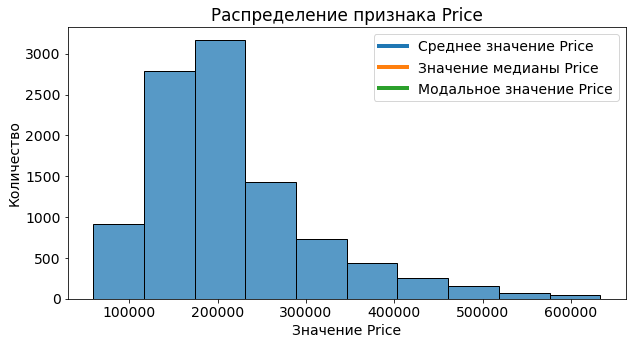

In [859]:
plt.figure(figsize = (10, 5))

sns.histplot(df_train['Price'], bins=10)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='Среднее значение Price',  linewidth=4)
plt.plot([target_median] * 10, y, label='Значение медианы Price',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Модальное значение Price', linewidth=4)
plt.xlabel('Значение Price')
plt.ylabel('Количество')

plt.title('Распределение признака Price')
plt.legend()
plt.show()

### Анализ признаков

In [860]:
# Используем функцию reduce_mem_usage, чтобы уменьшить размер памяти, занимаемой датафреймом 
reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


###### Square

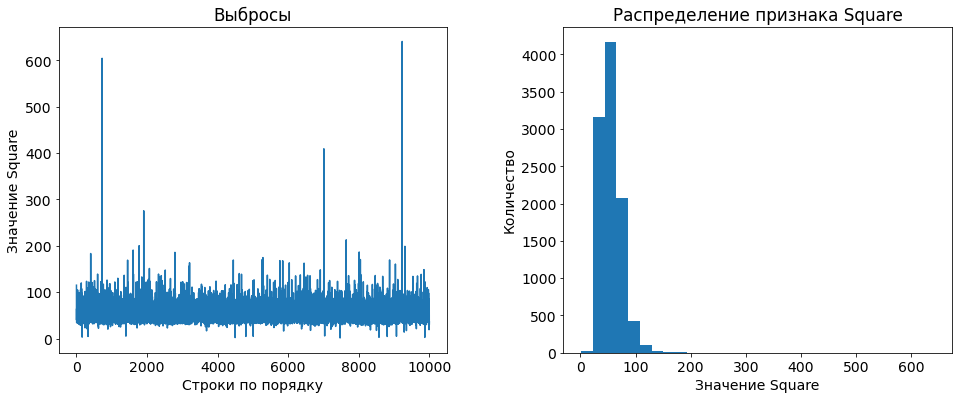

In [861]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
ax[0].plot(df_train['Square'])
ax[0].set_title('Выбросы')
ax[0].set_xlabel('Строки по порядку')
ax[0].set_ylabel('Значение Square')
ax[1].hist(df_train['Square'], bins=30)
ax[1].set_title('Распределение признака Square')
ax[1].set_xlabel('Значение Square')
ax[1].set_ylabel('Количество')
plt.show()

In [862]:
# Квантили для корректировки выбросов
qle_Square = df_train['Square'].quantile([0.025, 0.975])
qle_Square

0.025     32.105184
0.975    100.906249
Name: Square, dtype: float64

In [863]:
# Делаем замены значений Square меньших квантиля 0,025 и больших квантиля 0,975 на значение медианы
df_train.loc[(df_train['Square'] < qle_Square[0.025]) 
             | (df_train['Square'] > qle_Square[0.975]), 'Square'] = df_train['Square'].median()

###### Rooms

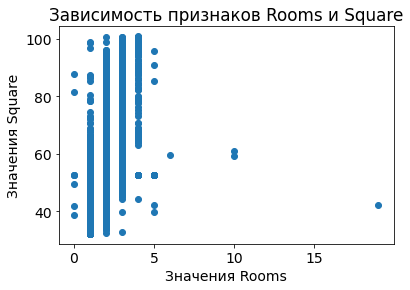

In [864]:
plt.scatter(df_train['Rooms'], df_train['Square'])
plt.xlabel('Значения Rooms')
plt.ylabel('Значения Square')

plt.title('Зависимость признаков Rooms и Square')
plt.show()

In [865]:
# Заменяем значение признака на 1, если признак равен 0
df_train.loc[df_train['Rooms']==0, 'Rooms'] = 1

In [866]:
# Значения комнат больше 5, заменяем на 5
df_train.loc[df_train['Rooms'] > 5, 'Rooms'] = 5

###### KitchenSquare

In [867]:
# Квантили
qle_KSquare = df_train['KitchenSquare'].quantile([0.025, 0.975])
qle_KSquare

0.025     0.0
0.975    13.0
Name: KitchenSquare, dtype: float64

In [868]:
# Делаем замены значений KitchenSquare меньших 6 и больших квантиля 0,975 на значение медианы
df_train.loc[(df_train['KitchenSquare'] < 6) 
             | (df_train['KitchenSquare'] > qle_KSquare[0.975]), 'KitchenSquare'] = df_train['KitchenSquare'].median()

###### LifeSquare

In [869]:
# Признак содержит пустые значения
df_train.loc[df_train['LifeSquare'].isna()].shape[0]

2113

In [870]:
# Квантили
qle_LSquare = df_train['LifeSquare'].quantile([0.025, 0.975])
qle_LSquare

0.025     5.91413
0.975    80.74810
Name: LifeSquare, dtype: float32

In [871]:
# Высчитаем добавочное значение для рассчёта жилой площади
df_meds = df_train.loc[df_train['LifeSquare'].between(6, qle_LSquare[0.975])
                       & ~df_train['LifeSquare'].isna(), ['Square', 'LifeSquare', 'KitchenSquare']]

In [872]:
df_meds['Delta'] = df_meds['Square']-df_meds['LifeSquare']-df_meds['KitchenSquare']

In [873]:
delta_median = df_meds['Delta'].median()
delta_median

11.33364486694336

In [874]:
# Заменим пустые значения жилой площади на разницу между общей площадью и пощадью кухни, 
#учитывая также добавочное значение delta_median 
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-delta_median

In [875]:
# Аналогичным образом поступим с выбросами
df_train.loc[(df_train['LifeSquare'] < 6)
             | (df_train['LifeSquare'] > qle_LSquare[0.975]), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-delta_median

In [876]:
df_train.loc[df_train['LifeSquare'] >= df_train['Square'], 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-delta_median

In [877]:
# Пересчитаем таким же образом жилую площадь, в случае если сумма площадти кухни и жилой площади больше общей площади
df_train.loc[(df_train['LifeSquare'] + df_train['KitchenSquare'])  
             > df_train['Square'], 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-delta_median

###### Districtid

In [878]:
# Список районов
districts = df_train['DistrictId'].value_counts().index.tolist()
# Количество районов
len(districts)

205

In [879]:
df_train['DistrictId'].value_counts().head(10)

27    851
1     652
23    565
6     511
9     294
62    247
30    228
58    179
53    174
21    165
Name: DistrictId, dtype: int64

###### Floor, HouseFloor

In [880]:
# Если этаж равен 0, то заменяем его на 1
df_train.loc[df_train['Floor'] == 0, 'Floor'] = df_train['Floor'].median()

In [881]:
# Квантили HouseFloor
qle_HFloor = df_train['HouseFloor'].quantile([0.025, 0.975])
qle_HFloor

0.025     0.0
0.975    25.0
Name: HouseFloor, dtype: float64

In [882]:
df_train.loc[(df_train['HouseFloor'] == 0)
             | (df_train['HouseFloor'] > qle_HFloor[0.975]), 'HouseFloor'] = df_train['HouseFloor'].median()

In [883]:
# Если номер этажа больше количества этажей в доме, то присваеваем этот номер признаку HouseFloor
df_train.loc[df_train['HouseFloor'] < df_train['Floor'], 'HouseFloor'] = df_train['Floor']

###### HouseYear

In [884]:
# Обработаем некорректные данные
df_train.loc[(df_train['HouseYear'] < 1900) | (df_train['HouseYear'] > 2021), 'HouseYear'] = df_train['HouseYear'].median()

In [885]:
# Построим график востребованности квартир определённого периода постройки
df_train['InterYear'] = df_train['HouseYear'] // 10 * 10

In [886]:
S_Years = df_train['InterYear'].value_counts().sort_index()
S_Years = pd.Series(S_Years.values, index = S_Years.index.astype(str))

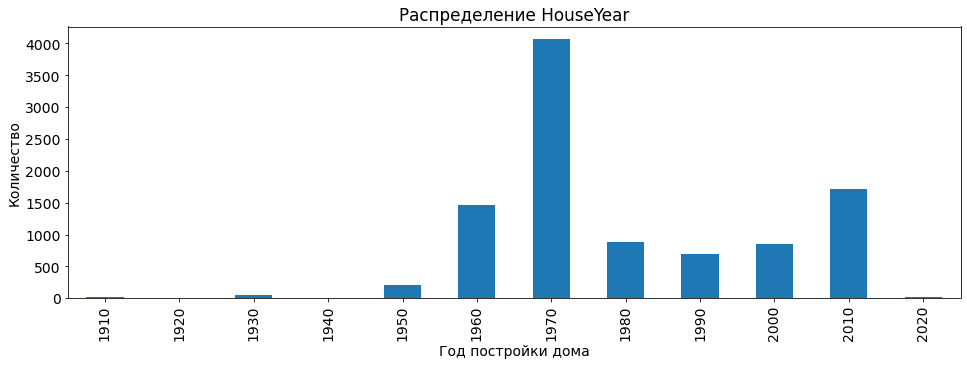

In [887]:
plt.figure(figsize = (16, 5))
plt.xlabel('Год постройки дома')
plt.ylabel('Количество')
plt.title('Распределение HouseYear')
S_Years.plot(kind='bar')
plt.show()

###### Ecology_1, Ecology_2, Ecology_3

In [888]:
df_train['Ecology_1'].head()

0    0.075424
1    0.118537
2    0.025609
3    0.007122
4    0.282798
Name: Ecology_1, dtype: float32

In [889]:
# Квантили
qle_Eco1 = df_train['Ecology_1'].quantile([0.025, 0.975])
qle_Eco1

0.025    0.000000
0.975    0.437885
Name: Ecology_1, dtype: float64

In [890]:
df_train['Ecology_1'].sort_values().head()

1612    0.0
8449    0.0
9204    0.0
810     0.0
7719    0.0
Name: Ecology_1, dtype: float32

In [891]:
df_train.loc[df_train['Ecology_1'] > qle_Eco1[0.975], 'Ecology_1'] = df_train['Ecology_1'].median()

In [892]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [893]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [894]:
# Заменим категории 'A' и 'B' на 0 и 1
df_train.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)

###### Social_1, Social_2, Social_3

In [895]:
# Квантили
qle_Soc1 = df_train['Social_1'].quantile([0.025, 0.975])
qle_Soc1

0.025     1.0
0.975    66.0
Name: Social_1, dtype: float64

In [896]:
df_train.loc[(df_train['Social_1'] < qle_Soc1[0.025]) 
             | (df_train['Social_1'] > qle_Soc1[0.975]), 'Social_1'] = df_train['Social_1'].median()

In [897]:
# Квантили
qle_Soc2 = df_train['Social_2'].quantile([0.025, 0.975])
qle_Soc2

0.025      264.0
0.975    14892.0
Name: Social_2, dtype: float64

In [898]:
df_train.loc[(df_train['Social_2'] < qle_Soc2[0.025]) 
             | (df_train['Social_2'] > qle_Soc2[0.975]), 'Social_2'] = df_train['Social_2'].median()

In [899]:
# Квантили
qle_Soc3 = df_train['Social_3'].quantile([0.025, 0.975])
qle_Soc3

0.025     0.0
0.975    93.0
Name: Social_3, dtype: float64

In [900]:
df_train.loc[(df_train['Social_3'] < qle_Soc3[0.025]) 
             | (df_train['Social_3'] > qle_Soc3[0.975]), 'Social_3'] = df_train['Social_3'].median()

###### Healthcare_1, Helthcare_2

In [901]:
# Слишком много пропусков, позже удалим признак
df_train.loc[df_train['Healthcare_1'].isna()].shape[0]

4798

In [902]:
# Квантили
qle_Hel2 = df_train['Helthcare_2'].quantile([0.025, 0.975])
qle_Hel2

0.025    0.0
0.975    5.0
Name: Helthcare_2, dtype: float64

In [903]:
df_train.loc[(df_train['Helthcare_2'] < qle_Hel2[0.025]) 
             | (df_train['Helthcare_2'] > qle_Hel2[0.975]), 'Helthcare_2'] = df_train['Helthcare_2'].median()

###### Shops_1, Shops_1

In [904]:
# Квантили
qle_Shops_1 = df_train['Shops_1'].quantile([0.025, 0.975])
qle_Shops_1

0.025     0.0
0.975    19.0
Name: Shops_1, dtype: float64

In [905]:
df_train.loc[(df_train['Shops_1'] < qle_Shops_1[0.025]) 
             | (df_train['Shops_1'] > qle_Shops_1[0.975]), 'Shops_1'] = df_train['Shops_1'].median()

In [906]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [907]:
# Заменим категории 'A' и 'B' на 0 и 1
df_train.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

### Добавление признаков

In [908]:
# Признак HouseAgePrice
house_age = pd.DataFrame({'HouseYear': df_train['HouseYear'], 'MedPrice': 0})
house_age.loc[df_train['HouseYear'] < 1960, 'MedPrice'] = df_train.loc[df_train['HouseYear'] < 1960, 'Price'].median()
house_age.loc[df_train['HouseYear'].between(1960, 1989, inclusive="both"), 'MedPrice'] = df_train.loc[df_train['HouseYear'].between(1960, 1989, inclusive="both"), 'Price'].median()
house_age.loc[df_train['HouseYear'] > 1989, 'MedPrice'] = df_train.loc[df_train['HouseYear'] > 1989, 'Price'].median()
house_age['MedPrice'].value_counts()

186649.3750    6415
203908.1875    3293
310512.3750     292
Name: MedPrice, dtype: int64

In [909]:
# Перенесем признак на тренировочный датасет
df_train = df_train.merge(house_age, on=['HouseYear'], how='left')

In [910]:
# Признак MedPriceByDistrict
med_price_dist = df_train.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
df_train = df_train.merge(med_price_dist, on=['DistrictId'], how='left')

In [911]:
med_soc_eco = df_train.groupby(['Social_1', 'Ecology_1'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedSocialEcoPrice'})
df_train = df_train.merge(med_soc_eco, on=['Social_1', 'Ecology_1'], how='left')

### Матрица корреляций

In [912]:
# Построим матрицу корреляций, чтобы посмотреть какие признаки влияют на целевую переменную
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,InterYear,MedPrice,MedPriceByDistrict,MedSocialEcoPrice
Id,1.00,0.00,-0.01,-0.02,-0.02,0.01,-0.00,-0.02,0.00,0.02,-0.00,0.03,0.02,-0.00,0.01,0.02,0.01,-0.00,-0.00,0.00,0.00,-0.01,0.01
DistrictId,0.00,1.00,0.05,-0.07,-0.09,0.13,-0.12,-0.24,-0.01,0.14,-0.04,0.46,0.41,0.38,0.38,0.35,0.42,-0.17,0.21,0.02,0.09,0.25,0.22
Rooms,-0.01,0.05,1.00,0.76,0.75,0.04,0.02,-0.01,0.00,-0.05,-0.01,0.09,0.08,0.02,0.04,0.06,0.08,-0.05,0.55,0.01,0.03,0.14,0.16
Square,-0.02,-0.07,0.76,1.00,0.97,0.02,0.07,0.04,0.05,-0.02,0.01,-0.06,-0.04,-0.05,-0.08,-0.03,-0.01,-0.08,0.50,0.04,0.03,0.07,0.09
LifeSquare,-0.02,-0.09,0.75,0.97,1.00,-0.11,0.06,0.05,-0.01,-0.02,0.04,-0.08,-0.07,-0.06,-0.11,-0.05,-0.03,-0.08,0.47,-0.02,-0.03,0.05,0.07
KitchenSquare,0.01,0.13,0.04,0.02,-0.11,1.00,0.02,0.02,0.24,-0.01,-0.05,0.13,0.12,0.05,0.12,0.07,0.08,-0.02,0.13,0.25,0.22,0.09,0.11
Floor,-0.00,-0.12,0.02,0.07,0.06,0.02,1.00,0.57,0.07,0.02,-0.02,-0.06,-0.04,-0.02,-0.12,0.01,0.01,0.02,0.17,0.06,0.01,0.11,0.16
HouseFloor,-0.02,-0.24,-0.01,0.04,0.05,0.02,0.57,1.00,0.11,0.01,0.02,-0.18,-0.15,-0.06,-0.12,-0.08,-0.06,0.07,0.08,0.09,0.01,0.03,0.10
HouseYear,0.00,-0.01,0.00,0.05,-0.01,0.24,0.07,0.11,1.00,-0.02,0.01,0.04,0.06,-0.02,-0.06,0.01,0.03,-0.01,0.08,0.99,0.65,0.05,0.04
Ecology_1,0.02,0.14,-0.05,-0.02,-0.02,-0.01,0.02,0.01,-0.02,1.00,-0.04,0.18,0.18,0.09,-0.09,0.09,0.15,0.09,-0.06,-0.01,-0.00,-0.05,-0.08


In [913]:
# Удалим малоинформативные признаки
df_train = df_train.drop(['Id', 'Healthcare_1', 'InterYear'], 1)

### Обучение модели

In [914]:
# Загрузим тренировочный и тестовый массивы заново и прогоним через функцию оптимизации занимаемой памяти
df_train = pd.read_csv(DATASET_PATH_TRAIN)
df_test = pd.read_csv(DATASET_PATH_TEST)
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [915]:
y = df_train['Price']
X = df_train.drop(columns=['Price'], axis=1)

In [916]:
# Разделяем массив на тренировочную и валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [917]:
dp = DataPreprocessor()

In [918]:
# высчитываем метрики по тренировочному массиву
dp.fit(X_train)

In [919]:
# Обрабатываем пропуски, выбросы и некорректные значения на тренировочном и валидационном массивах
X_train = dp.transform(X_train)

In [920]:
X_valid = dp.transform(X_valid)

In [921]:
features = {'house_age': house_age, 'med_price_dist': med_price_dist, 'med_soc_eco': med_soc_eco}

In [922]:
# Добавляем новые признаки
X_train = add_features(X_train, features)

In [923]:
X_valid = add_features(X_valid, features)

Train R2:	0.702
Test R2:	0.653


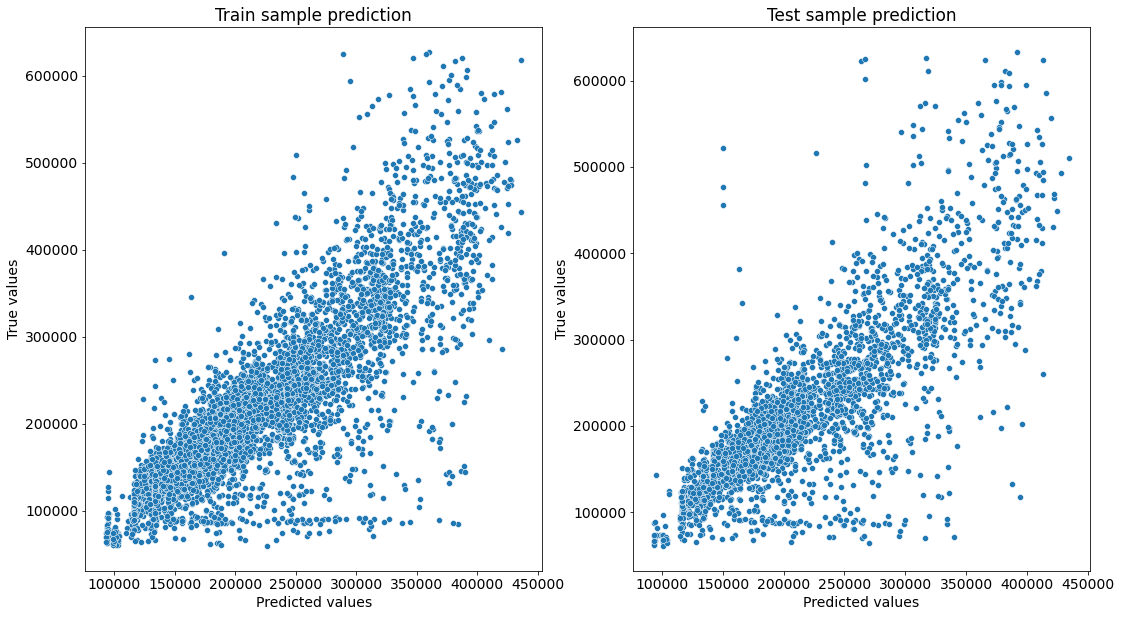

In [924]:
# Обучаем модель RandomForestRegressor и сравниваем предсказания
model_RFR = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=42)
model_RFR.fit(X_train, y_train)
y_train_preds = model_RFR.predict(X_train)
y_valid_preds = model_RFR.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)
# Разница между предсказаниями не первышает 10% от тестового R2, значит переобучения не было

### Важность признаков

In [925]:
# Выведем признаки в порядке наибольшей значимости
feature_importances = pd.DataFrame(zip(X_train.columns, model_RFR.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.288901
1,Rooms,0.240132
13,Social_3,0.141463
11,Social_1,0.067525
12,Social_2,0.054767
0,DistrictId,0.048854
3,LifeSquare,0.045271
8,Ecology_1,0.029332
4,KitchenSquare,0.029326
15,Shops_1,0.016378


### Формирование файла с прогнозами

In [926]:
# Загрузим пример файла с прогнозами и заменим столбец Price на результаты, предсказанные на тестовой выборке
df_sample = pd.read_csv(DATASET_PATH_SAMPLE)
df_sample.columns

Index(['Id', 'Price'], dtype='object')

In [927]:
df_sample.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [928]:
df_test = dp.transform(df_test)

In [929]:
df_test = add_features(df_test, features)

In [930]:
y_test_preds = model_RFR.predict(df_test)

In [931]:
df_sample['Price'] = y_test_preds

In [932]:
df_sample.head()

,Id,Price
0,4567,157453.769129
1,5925,129626.291033
2,960,161356.260037
3,3848,146644.831990
4,746,251728.737387


In [933]:
# Выгружаем файл для загрузки на kaggle
df_sample.to_csv("./predictions_.csv", index=False)

Аккаунт на kaggle: Baturina Yuliya (Батурина Юлия)